<img src="simple_pyro_exercise.png"/>

In [1]:
import numpy as np
import torch
from torch.distributions import constraints
import matplotlib.pyplot as plt

import pyro
from pyro.distributions import Normal, Gamma, MultivariateNormal
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import pyro.optim as optim

## Generate some data

In [2]:
# Sample data
np.random.seed(123)
N = 100
correct_mean = 5
correct_precision = 1
data = torch.tensor(np.random.normal(loc=correct_mean, scale=np.sqrt(1./correct_precision), size=N), dtype=torch.float)


## Our model specification

In [3]:
def model(data):
    gamma = pyro.sample("gamma", Gamma(torch.tensor(1.), torch.tensor(1.)))
    mu = pyro.sample("mu", Normal(torch.zeros(1), torch.tensor(10000.0)))
    with pyro.plate("data", len(data)):
        pyro.sample("x", Normal(loc=mu, scale=torch.sqrt(1. / gamma)), obs=data)

## Our guide specification

In [4]:
def guide(data=None):
    rate = pyro.param("rate", torch.tensor(1.), contrainst=constrain.positive)
    conc = pyro.param("conc", torch.tensor(1.), contrainst=constrain.positive)
    pyro.sample("gamma", Gamma(rate, conc))

    mu_mean = pyro.param("mu_mean", torch.tensor(0.))
    mu_scale = pyro.param("mu_scale", torch.tensor(1.), contrainst=constrain.positive)
    pyro.sample("mu", Normal(mu_mean, mu_scale))

## Do learning

In [5]:
# setup the optimizer
adam_args = {"lr": 0.01}
optimizer = Adam(adam_args)

pyro.clear_param_store()
svi = SVI(model, guide, optimizer, loss=Trace_ELBO(), num_samples=10)
train_elbo = []
# training loop
for epoch in range(3000):
    loss = svi.step(data)
    train_elbo.append(-loss)
    if (epoch % 500) == 0:
        print("[epoch %03d] average training loss: %.4f" % (epoch, loss))

[epoch 000] average training loss: 1599.6830
[epoch 500] average training loss: 546.2211
[epoch 1000] average training loss: 284.1279
[epoch 1500] average training loss: 185.3350
[epoch 2000] average training loss: 195.8745
[epoch 2500] average training loss: 178.9226


In [6]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

rate tensor(1.8581, requires_grad=True)
conc tensor(2.1757, requires_grad=True)
mu_mean tensor(5.0201, requires_grad=True)
mu_scale tensor(0.1044, requires_grad=True)


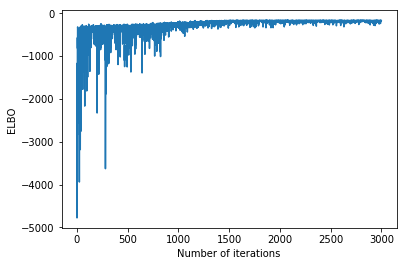

In [7]:
plt.plot(range(len(train_elbo)), train_elbo)
plt.xlabel("Number of iterations")
plt.ylabel("ELBO")
plt.show()